### In this notebook we are going to compare the f1-score for different languages based on different topics to see if the topics has impact on discovering the native language of English-written essays.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path

import plotly.figure_factory as ff
import plotly.io as pio

import sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer

import spacy
from spacy.lang.en import STOP_WORDS

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
icle = pd.read_csv('icle_toefl_tagged_readability.csv')
toefl = pd.read_csv('../toefl.csv')

In [4]:
toefl.head()

,Unnamed: 0,Filename,text,Language,Proficiency,pos,readability_words,readability_sents
0,0,88.txt,Some people might think that traveling in a gr...,KOR,high,DET NOUN AUX VERB SCONJ VERB ADP DET NOUN VERB...,3.695962,23.388889
1,1,278.txt,IThe importance and popularity of travelling i...,DEU,medium,DET NOUN CCONJ NOUN ADP VERB AUX ADV VERB PUNC...,3.829480,23.066667
2,2,348.txt,"It is an important decision, how to plan your ...",TUR,high,PRON AUX DET ADJ NOUN PUNCT SCONJ PART VERB PR...,4.126551,25.187500
3,3,666.txt,Some people believe that young people can enjo...,ZHO,medium,DET NOUN VERB SCONJ ADJ NOUN AUX VERB NOUN ADJ...,3.812808,15.037037
4,4,733.txt,Travelling is usually considered as good recr...,TEL,medium,NOUN AUX SPACE ADV VERB ADP ADJ NOUN SPACE ADP...,4.072581,26.571429


In [5]:
icle.head()

,Unnamed: 0,Unnamed: 0.1,File_name,Native_language,Country,Gender,Age,1st_FL,2nd_FL,3rd_FL,...,Length_in_words,Type,Conditions,Reference_tools,Examination,Comments,Text,pos,readability_words,readability_sents
0,0,0,FRUC2027,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,896,Literary,Timed,Yes,Yes,-,Different ways of managing kinds of wastes ar...,SPACE ADJ NOUN ADP VERB NOUN ADP NOUN AUX VERB...,4.380634,20.655172
1,1,1,FRUC2028,FRA,Belgium,Female,20.0,NaN,NaN,NaN,...,657,Literary,Timed,Yes,Yes,-,"Nowadays, people around the world pay more at...",SPACE ADV PUNCT NOUN ADP DET NOUN VERB ADJ NOU...,4.502755,22.000000
2,2,2,FRUC2029,FRA,Belgium,Female,22.0,German,Dutch,NaN,...,712,Literary,Timed,Yes,Yes,-,There are a million of trush produced by Hong...,SPACE PRON VERB DET NUM ADP NOUN VERB ADP PROP...,4.303290,16.642857
3,3,3,FRUC2030,FRA,Belgium,Female,21.0,Dutch,NaN,NaN,...,652,Literary,Timed,Yes,Yes,-,"In Hong Kong, majority of waste management is...",SPACE ADP PROPN PROPN PUNCT NOUN ADP NOUN NOUN...,4.421898,20.147059
4,4,4,FRUC2032,FRA,Belgium,Female,20.0,Dutch,NaN,NaN,...,1870,Literary,Timed,Yes,Yes,-,There are various way for treating waste mate...,SPACE PRON VERB ADJ NOUN ADP VERB NOUN NOUN AD...,4.519525,18.406250


In [6]:
desired_languages = ['JPN', 'DEU', 'KOR', 'ZHO', 'SPA', 'TUR', 'ITA', 'FRA']
toefl = toefl[toefl['Language'].isin(desired_languages)]

In [7]:
toefl.text.replace(r'\n+',' ', regex=True, inplace=True)
icle.Text.replace(r'\n+', ' ', regex=True, inplace=True)

In [8]:
X_toefl = toefl.drop(columns=['Unnamed: 0', 'Filename', 'Language', 'Proficiency'])
y_toefl = toefl.Language

X_icle = icle.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'File_name', 'Native_language', 'Country', 'Gender', 'Age', '1st_FL', '2nd_FL', '3rd_FL', '1st_Lhome',
                     '2nd_Lhome', '3rd_Lhome', 'Years_Eng_school', 'Years_Eng_uni','Months_in_Eng_country', 'Institution',
                     'Topic', 'Length_in_words', 'Type', 'Conditions', 'Reference_tools', 'Examination', 'Comments'])
X_icle = X_icle.rename(columns={'Text':'text'})
y_icle = icle.Native_language

In [9]:
unique_topics = icle['Topic'].unique()
num_unique_topics = len(unique_topics)
print(f"There are {num_unique_topics} unique topics.")

There are 643 unique topics.


In [10]:
# Create the scaler, vectorizers, and preprocessor
scaler = StandardScaler()
vect1 = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=False, tokenizer=str.split)
vect2 = TfidfVectorizer(max_features=100, ngram_range=(1, 4), lowercase=False, tokenizer=str.split)

preprocessor = make_column_transformer(
    (scaler, ['readability_words', 'readability_sents']),
    (vect1, 'text'),
    (vect2, 'pos'),
    remainder='passthrough'
)

# Create the SVM classifier with beneficial parameters
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)

# Create the pipeline with the preprocessor and SVM classifier
pipe = make_pipeline(preprocessor, svm_clf)

# Fit the pipeline on the training data
pipe.fit(X_toefl, y_toefl)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['readability_words',
                                                   'readability_sents']),
                                                 ('tfidfvectorizer-1',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'text'),
                                             

              precision    recall  f1-score   support

         DEU       0.78      0.49      0.60       445
         FRA       0.40      0.83      0.54       314
         ITA       0.67      0.66      0.66       398
         JPN       0.80      0.58      0.67       366
         KOR       0.57      0.59      0.58       400
         SPA       0.54      0.44      0.49       250
         TUR       0.53      0.86      0.66       286
         ZHO       0.86      0.66      0.75       982

    accuracy                           0.64      3441
   macro avg       0.64      0.64      0.62      3441
weighted avg       0.69      0.64      0.64      3441



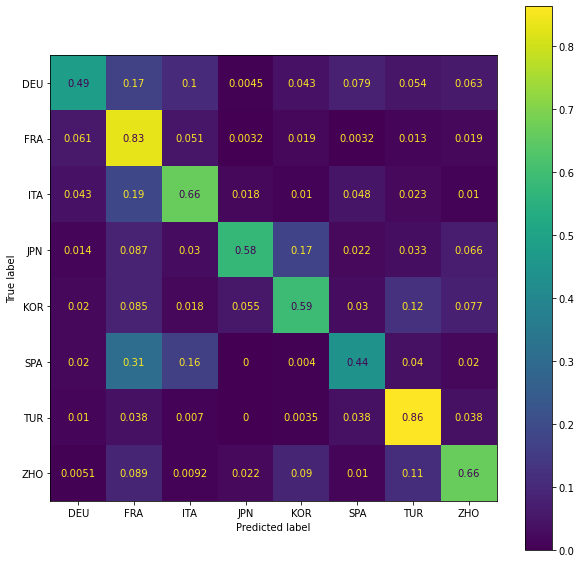

In [11]:
y_test_icle_pred = pipe.predict(X_icle)

print(classification_report(y_icle, y_test_icle_pred))

cm = confusion_matrix(y_icle, y_test_icle_pred, labels=pipe.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

### Calculate f1-score for 5 most frequent topics

In [21]:
#five most frequent topics in this subset
topic_frequency = icle['Topic'].value_counts()
print(topic_frequency.head(5))

Discuss the advantages and disadvantages of banning smoking in restaurants                                                                                                             156
Discuss the advantages and disadvantages of students using credit cards                                                                                                                149
Most university degrees are theoretical and do not prepare students for the real world. They are therefore of very little value                                                        140
Some people say that in our modern world, dominated by science and technology and industrialisation, there is no longer a place for dreaming and imagination. What is your opinion?    100
Discuss the pros and cons of importing professionals i.e. qualified professionals, technical staff, administrators and managerial personnel from Mainland China into Hong Kong          94
Name: Topic, dtype: int64


In [22]:
# Defining the topics
topics = [
    "Discuss the advantages and disadvantages of banning smoking in restaurants",
    "Discuss the advantages and disadvantages of students using credit cards",
    "Most university degrees are theoretical and do not prepare students for the real world. They are therefore of very little value",
    "Some people say that in our modern world, dominated by science and technology and industrialisation, there is no longer a place for dreaming and imagination. What is your opinion?",
    "Discuss the pros and cons of importing professionals i.e. qualified professionals, technical staff, administrators and managerial personnel from Mainland China into Hong Kong"
]

# Filtering the DataFrame
filtered_topic = icle[icle['Topic'].isin(topics)]

In [46]:
# Rename the 'Text' column in the filtered_topic DataFrame
filtered_topic = filtered_topic.rename(columns={'Text': 'text'})

# List the desired column order from X_toefl
desired_column_order = ['text', 'pos', 'readability_words', 'readability_sents']

# Reorder the columns in filtered_topic_features
filtered_topic_features = filtered_topic_features[desired_column_order]

# Make predictions on the filtered topic subset
y_filtered_topic_pred = pipe.predict(filtered_topic_features)

# Create a DataFrame with the desired columns for the 5 most frequent topics
result_df = pd.DataFrame({
    'Essay': filtered_topic['text'],  # Assuming 'text' is the column with the essay text
    'Actual Language': filtered_topic['Native_language'],
    'Predicted Language': y_filtered_topic_pred,
    'Topic': filtered_topic['Topic']
})

print(result_df)


                                                  Essay Actual Language  \
15     Due to the limited land in Hong Kong, the pri...             ZHO   
16     Tons of garbages have been created in Hong Ko...             ZHO   
46     With the increasing number of people travel t...             ZHO   
47     Hong Kong and the mainland China are closely ...             ZHO   
48     Railway is a transportation network which pro...             ZHO   
...                                                 ...             ...   
3436   The university should be the institution in w...             TUR   
3437   If someone asks me the happiest day in my lif...             TUR   
3438   Today more and more people from young generat...             TUR   
3439   In the world of today, especially in Turkey. ...             TUR   
3440   Education is very important in people's lives...             TUR   

     Predicted Language                                              Topic  
15                  ZH

In [48]:
result_df

,Essay,Actual Language,Predicted Language,Topic
15,"Due to the limited land in Hong Kong, the pri...",ZHO,ZHO,Discuss the advantages and disadvantages of ba...
16,Tons of garbages have been created in Hong Ko...,ZHO,ZHO,Discuss the pros and cons of importing profess...
46,With the increasing number of people travel t...,ZHO,ZHO,Discuss the pros and cons of importing profess...
47,Hong Kong and the mainland China are closely ...,ZHO,ZHO,Discuss the pros and cons of importing profess...
48,Railway is a transportation network which pro...,ZHO,ZHO,Discuss the pros and cons of importing profess...
...,...,...,...,...
3436,The university should be the institution in w...,TUR,TUR,Most university degrees are theoretical and do...
3437,If someone asks me the happiest day in my lif...,TUR,TUR,Most university degrees are theoretical and do...
3438,Today more and more people from young generat...,TUR,TUR,Most university degrees are theoretical and do...
3439,"In the world of today, especially in Turkey. ...",TUR,TUR,Most university degrees are theoretical and do...


In [51]:
from sklearn.metrics import f1_score

# Create an empty dictionary to store the F1 scores for each language
f1_scores_languages = {}

# Get the unique languages
unique_languages = result_df['Actual Language'].unique()

# Loop over the unique languages
for language in unique_languages:
    # Subset the DataFrame for the current language
    language_df = result_df[result_df['Actual Language'] == language]
    
    # Calculate the F1 score for the current language
    f1 = f1_score(language_df['Actual Language'], language_df['Predicted Language'], average='weighted')
    
    # Store the F1 score in the dictionary
    f1_scores_languages[language] = f1

# Convert the dictionary to a DataFrame for better visualization
f1_scores_languages_df = pd.DataFrame(list(f1_scores_languages.items()), columns=['Language', 'F1 Score'])
f1_scores_languages_df

,Language,F1 Score
0,ZHO,0.819892
1,SPA,0.571429
2,FRA,0.895238
3,ITA,0.640000
4,DEU,0.000000
5,TUR,0.982143


In [52]:
# Create an empty dictionary to store the F1 scores for each topic
f1_scores_topics = {}

# Get the unique topics
unique_topics = result_df['Topic'].unique()

# Loop over the unique topics
for topic in unique_topics:
    # Subset the DataFrame for the current topic
    topic_df = result_df[result_df['Topic'] == topic]
    
    # Calculate the F1 score for the current topic
    f1 = f1_score(topic_df['Actual Language'], topic_df['Predicted Language'], average='weighted')
    
    # Store the F1 score in the dictionary
    f1_scores_topics[topic] = f1

# Convert the dictionary to a DataFrame for better visualization
f1_scores_topics_df = pd.DataFrame(list(f1_scores_topics.items()), columns=['Topic', 'F1 Score'])
f1_scores_topics_df

,Topic,F1 Score
0,Discuss the advantages and disadvantages of ba...,0.861314
1,Discuss the pros and cons of importing profess...,0.802548
2,Discuss the advantages and disadvantages of st...,0.798387
3,"Some people say that in our modern world, domi...",0.602038
4,Most university degrees are theoretical and do...,0.767785


In [53]:
from sklearn.metrics import f1_score

# Create a list to store the F1 scores for each topic and language
f1_scores = []

# Get the unique topics
unique_topics = result_df['Topic'].unique()

# Get the unique languages
unique_languages = result_df['Actual Language'].unique()

# Loop over the unique topics
for topic in unique_topics:
    # Loop over the unique languages
    for language in unique_languages:
        # Subset the DataFrame for the current topic and language
        topic_language_df = result_df[(result_df['Topic'] == topic) & (result_df['Actual Language'] == language)]
        
        # Calculate the F1 score for the current topic and language, if the subset dataframe is not empty
        if not topic_language_df.empty:
            f1 = f1_score(topic_language_df['Actual Language'], topic_language_df['Predicted Language'], average='weighted')
            
            # Store the F1 score and the support (number of essays) in the list
            f1_scores.append((topic, language, f1, topic_language_df.shape[0]))

# Convert the list to a DataFrame for better visualization
f1_scores_df = pd.DataFrame(f1_scores, columns=['Topic', 'Language', 'F1 Score', 'Support'])

# Round the F1 Score to 2 decimal places
f1_scores_df['F1 Score'] = f1_scores_df['F1 Score'].round(2)

In [54]:
f1_scores_df

,Topic,Language,F1 Score,Support
0,Discuss the advantages and disadvantages of ba...,ZHO,0.86,156
1,Discuss the pros and cons of importing profess...,ZHO,0.80,94
2,Discuss the advantages and disadvantages of st...,ZHO,0.80,149
3,"Some people say that in our modern world, domi...",SPA,0.61,32
4,"Some people say that in our modern world, domi...",FRA,0.90,44
5,"Some people say that in our modern world, domi...",ITA,0.56,23
6,"Some people say that in our modern world, domi...",DEU,0.00,1
7,Most university degrees are theoretical and do...,ZHO,0.77,40
8,Most university degrees are theoretical and do...,SPA,0.50,18
9,Most university degrees are theoretical and do...,FRA,0.88,14


In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

toefl_texts = " ".join(toefl['text'].tolist())  # Concatenate all texts from the first dataframe into a single string
similarity_results = {}  # Dictionary to store similarity results for each topic

vectorizer = TfidfVectorizer()

# Loop over topics
for topic in topics:
    # Get texts from the second dataframe based on the current topic
    icle_texts = icle[icle['Topic'] == topic]['Text'].tolist()

    # Combine all texts
    all_texts = [toefl_texts] + icle_texts  # Here toefl_texts is treated as a single document

    # Compute TF-IDF vectors for all texts
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Compute cosine similarity between the toefl_texts and each text in icle_texts for the current topic
    similarity_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

    # Store similarity scores in dictionary
    similarity_results[topic] = similarity_scores

# Print similarity scores for each topic
for topic, scores in similarity_results.items():
    print(f"Topic: {topic}\nScores: {scores}\n")


Topic: Discuss the advantages and disadvantages of banning smoking in restaurants
Scores: [[0.41463019 0.43822123 0.37313787 0.40396549 0.3365298  0.40521529
  0.32504743 0.41655253 0.40631295 0.47074761 0.54093013 0.52129783
  0.39547427 0.53478978 0.46635169 0.40357404 0.45045664 0.43039096
  0.46213556 0.47148309 0.40994879 0.47207475 0.34277253 0.38692856
  0.35481701 0.44676987 0.33312892 0.37408998 0.38854806 0.34275484
  0.37575489 0.42191517 0.49863603 0.35568318 0.41751089 0.40696428
  0.43705612 0.38040852 0.34274351 0.37128672 0.36808128 0.29990054
  0.3353227  0.42600815 0.4450085  0.35431993 0.30921432 0.44460367
  0.48982816 0.32679775 0.33043152 0.32791315 0.33867266 0.4709177
  0.41756101 0.41641234 0.48233936 0.41682917 0.31878125 0.43340517
  0.41777483 0.38989016 0.34631351 0.44332629 0.3757399  0.49982753
  0.43209555 0.39035813 0.39444616 0.43727931 0.45069298 0.42908168
  0.38478041 0.37960306 0.41795299 0.4562996  0.43753259 0.36573021
  0.44520895 0.34406624 0.4

In [59]:
import numpy as np

# Initialize an empty dictionary to hold the average similarity scores for each topic
avg_similarity_scores = {}

# Assuming toefl_texts is a list of all text from the first dataframe
toefl_texts = toefl['text'].tolist()

# Loop over each topic
for topic in topics:
    # Get texts for the current topic
    icle_texts = icle[icle['Topic'] == topic]['Text'].tolist()
    
    # Combine all texts
    all_texts = toefl_texts + icle_texts
    
    # Compute TF-IDF vectors for all texts
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    # Compute cosine similarity between all texts from the first dataframe
    # and all texts from the second dataframe based on the specified topic
    similarity_matrix = cosine_similarity(tfidf_matrix[:len(toefl_texts)], tfidf_matrix[len(toefl_texts):])
    
    # Compute average similarity score for the current topic
    avg_similarity_scores[topic] = np.mean(similarity_matrix)

# Print average similarity scores for each topic
for topic, scores in similarity_results.items():
    avg_score = np.squeeze(scores).mean()
    print(f"Topic: {topic}\nAverage Score: {round(avg_score, 2)}\n")

Topic: Discuss the advantages and disadvantages of banning smoking in restaurants
Average Score: 0.41

Topic: Discuss the advantages and disadvantages of students using credit cards
Average Score: 0.4

Topic: Most university degrees are theoretical and do not prepare students for the real world. They are therefore of very little value
Average Score: 0.52

Topic: Some people say that in our modern world, dominated by science and technology and industrialisation, there is no longer a place for dreaming and imagination. What is your opinion?
Average Score: 0.54

Topic: Discuss the pros and cons of importing professionals i.e. qualified professionals, technical staff, administrators and managerial personnel from Mainland China into Hong Kong
Average Score: 0.43

